In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import kstest
from scipy.stats import shapiro
import seaborn as sns
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from sklearn.decomposition import PCA
from pypfopt import plotting    
from pypfopt import black_litterman, risk_models, BlackLittermanModel, expected_returns
from scipy.optimize import minimize

A1. We begin with the first question, where we are asked to compute some statistcal propertiers of two datasets, after importing them taking into consideration how they are formatted in the excel spreedsheet we calculate, after substituting missing values with a periodic mean directly in the excel sheet:
log_returns $= ln(\frac{p_t}{p_{t-1}})$ both for the daily and the monthly dataset.
The mean, 
The SD as $\sqrt{\frac{\Sigma_i \left| x_i-\bar{x} \right|}{N}}$, the skewness and the kurtosis. 




In [ ]:
df = pd.read_excel('sec.xlsx',skiprows=2, parse_dates=['date'], index_col=0, sheet_name=None)



df_daily = df['stocks daily']

df_monthly = df['stocks monthly']




log_returns_daily = np.log(df_daily / df_daily.shift(1))
log_returns_monthly = np.log(df_monthly / df_monthly.shift(1))







daily_summary_table = pd.DataFrame({
    'MeanRtr': log_returns_daily.mean(numeric_only=True),
    'SDRtr': log_returns_daily.std(numeric_only=True),
    'VarRtr': log_returns_daily.var(numeric_only=True),
    'SkewRtr': log_returns_daily.skew(numeric_only=True),
    'KurtRtr': log_returns_daily.kurt(numeric_only=True),
})





daily_summary_tableprice = pd.DataFrame({
    'MeanPrc': df_daily.mean(numeric_only=True),
    'SDPrc': df_daily.std(numeric_only=True),
    'VarPrc': df_daily.var(numeric_only=True),
    'SkewPrc': df_daily.skew(numeric_only=True),
    'KurtPrc': df_daily.kurt(numeric_only=True),
})



monthly_summary_tablereturn = pd.DataFrame({
    'MeanRtr': log_returns_monthly.mean(numeric_only=True),
    'SDRtr': log_returns_monthly.std(numeric_only=True),
    'VarRtr': log_returns_monthly.var(numeric_only=True),
    'SkewRtr': log_returns_monthly.skew(numeric_only=True),
    'KurtRtr': log_returns_monthly.kurt(numeric_only=True),
})




monthly_summary_tableprice = pd.DataFrame({
    'MeanPrc': df_monthly.mean(numeric_only=True),
    'SDPrc': df_monthly.std(numeric_only=True),
    'VarPrc': df_monthly.var(numeric_only=True), 
    'SkewPrc': df_monthly.skew(numeric_only=True),
    'KurtPrc': df_monthly.kurt(numeric_only=True),
 })



A2. We compute the variance-covariance and the correlation matrices. 

For each stock the covariance is calculated as:
$Cov(X,Y)=\frac{\Sigma_i(x_i-\bar{x})(y_i-\bar{y})}{N}$
And the correlation = $Corr(X,Y)=\frac{Cov(X,Y)}{\sigma_x\cdot\sigma_y}$



In [ ]:
corr_day = log_returns_daily.corr()
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust size of figure
sns.heatmap(corr_day, cmap='plasma', cbar=True, ax=ax, vmin=-1, vmax=1,
            xticklabels=True, yticklabels=True)  # Add color bar
plt.title('Correlation Matrix Heatmap of Daily Logaritmic Returns')
plt.yticks(rotation=0)  # Rotate y-axis labels
plt.xticks(fontsize=5)  # Reduce x-axis font size
plt.yticks(fontsize=5)  # Reduce y-axis font size





#calculate the covariance matrix
#print(returndaily)

covariance_matrix_daily = log_returns_daily.cov()
covariance_matrix_monthly = log_returns_monthly.cov()

#visualize the covariance matrix
print("daily covariance Matrix:")
print(covariance_matrix_monthly)

#create a heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(covariance_matrix_monthly, cmap= 'plasma', annot=False, linewidths=.5, vmin=-0.000616, vmax=0.02, xticklabels=True, yticklabels=True)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.title('Heatmap of monthly Covariance Matrix')
plt.show()
#THIS WAS THE PART FOR COVARIANCE-VARIANCE MATRIX BOTH DAILY AND MONTHLY


A3. We choose n stocks from our universe, using PCA and taking into consideration the stocks that most loadings on the principal components. 

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(corr_day)

pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
pca_df['stocks daily'] = log_returns_daily.columns


# Sort the DataFrame by 'PC1' and 'PC2'
pca_df = pca_df.sort_values(['PC1', 'PC2'])



# Plot 'PC1' vs 'PC2'
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add labels to the points
for i, stock in enumerate(pca_df['stocks daily']):
    plt.annotate(stock, (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), fontsize=5)

plt.show()
print(pca_df)

A4. Once the stocks have been choosen, we plot the behavior both for daily and monthly frequencies. We also create 2 dataframes with only them. 

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple', 'pink', 'brown']

df_daily[['RATTI', 'BASTOGI', 'MONRIF', 'GAMBERO ROSSO', 'BEEWIZE', 'ECOSUNTEK', 'VIANINI INDR.', 'ENERVIT', 'SABAF', 'ALERION CLEAN POWER']].plot(color=colors)
plt.title('Daily price')
plt.xlabel('Date')
plt.ylabel('price')
plt.show()

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple', 'pink', 'brown']

df_monthly[['RATTI', 'BASTOGI', 'MONRIF', 'GAMBERO ROSSO', 'BEEWIZE', 'ECOSUNTEK', 'VIANINI INDR.', 'ENERVIT', 'SABAF', 'ALERION CLEAN POWER']].plot(color=colors)
plt.title('Monthly price')
plt.xlabel('Date')
plt.ylabel('price')
plt.show()



df_stocks_daily = pd.DataFrame({
    'ILLIMITY BANK': df_daily['ILLIMITY BANK'],
    'AQUAFIL': df_daily['AQUAFIL'],
    'VALSOIA': df_daily['VALSOIA'],
    'PIRELLI': df_daily['PIRELLI'],
    'HERA': df_daily['HERA'],
    'ENEL': df_daily['ENEL'],
    'DAVIDE CAMPARI MILANO': df_daily['DAVIDE CAMPARI MILANO'],
    'BUZZI': df_daily['BUZZI'],
    'CEMBRE': df_daily['CEMBRE'],
    'AMPLIFON': df_daily['AMPLIFON'],
    'STELLANTIS': df_daily['STELLANTIS'],
    'ALERION CLEAN POWER': df_daily['ALERION CLEAN POWER'],
})


df_stocks_monthly = pd.DataFrame({
    'ILLIMITY BANK': df_monthly['ILLIMITY BANK'],
    'AQUAFIL': df_monthly['AQUAFIL'],
    'VALSOIA': df_monthly['VALSOIA'],
    'PIRELLI': df_monthly['PIRELLI'],
    'HERA': df_monthly['HERA'],
    'ENEL': df_monthly['ENEL'],
    'DAVIDE CAMPARI MILANO': df_monthly['DAVIDE CAMPARI MILANO'],
    'BUZZI': df_monthly['BUZZI'],
    'CEMBRE': df_monthly['CEMBRE'],
    'AMPLIFON': df_monthly['AMPLIFON'],
    'STELLANTIS': df_monthly['STELLANTIS'],
    'ALERION CLEAN POWER': df_monthly['ALERION CLEAN POWER'],
})

A5. Leveraging the pypfopt library in python we compute the MV optimal portfolio allocation. 

In [ ]:
selected_stocks = ['RATTI', 'BASTOGI', 'MONRIF', 'GAMBERO ROSSO', 'BEEWIZE', 'ECOSUNTEK', 'VIANINI INDR.', 'ENERVIT', 'SABAF', 'ALERION CLEAN POWER']

selected_normal_pricemonthly = df_monthly[selected_stocks]
mu = mean_historical_return (selected_normal_pricemonthly, frequency=12)
S= CovarianceShrinkage(selected_normal_pricemonthly, frequency=12).ledoit_wolf()



ef= EfficientFrontier(mu, S, weight_bounds=(-1,1)) #weight_bounds=(-1,1) to allow short.
weights = ef.max_sharpe(risk_free_rate=0)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True, risk_free_rate=0)

A6-7. We output the optimal weights for our selected stocks, and calculate statistical properties for the portfolios.

In [ ]:
selected_normal_pricedaily = df_daily[selected_stocks]
selected_normal_pricemonthly = df_monthly[selected_stocks]


S_daily = CovarianceShrinkage(selected_normal_pricedaily, frequency=252).ledoit_wolf()
mu_daily = mean_historical_return(selected_normal_pricedaily, frequency=252)
print(S_daily)

# Setup EfficientFrontier for daily data
ef_daily = EfficientFrontier(mu_daily, S_daily)
weights_daily = ef_daily.max_sharpe(risk_free_rate=0)
cleaned_weights_daily = ef_daily.clean_weights()
perf_daily = ef_daily.portfolio_performance(verbose=True, risk_free_rate=0)


S_monthly = CovarianceShrinkage(selected_normal_pricemonthly, frequency=12).ledoit_wolf()
mu_monthly = mean_historical_return(selected_normal_pricemonthly, frequency=12)  # Assuming monthly frequency

# Setup EfficientFrontier for monthly data
ef_monthly = EfficientFrontier(mu_monthly, S_monthly)
ef_monthly.add_objective(objective_functions.L2_reg, gamma=3)
weights_monthly = ef_monthly.max_sharpe(risk_free_rate=0)
cleaned_weights_monthly = ef_monthly.clean_weights()


perf_monthly = ef_monthly.portfolio_performance(verbose=True, risk_free_rate=0)


# Create DataFrame for weights
weights_df = pd.DataFrame({
    'weights_daily': cleaned_weights_daily,
    'weights_monthly': cleaned_weights_monthly,
})

# Create DataFrame for performance
perf_df = pd.DataFrame({
    'perf_daily': perf_daily,
    'perf_monthly': perf_monthly
}, index=['Expected Return', 'Volatility', 'Sharpe Ratio'])

# Concatenate the DataFrames
unc_port_perf = pd.concat([weights_df, perf_df])


selected_ln_pricedaily = np.log(selected_normal_pricedaily)
selected_ln_pricemonthly = np.log(selected_normal_pricemonthly)

portfolio_returns_daily = (selected_ln_pricedaily * cleaned_weights_daily).sum(axis=1)
portfolio_returns_monthly = (selected_ln_pricemonthly * cleaned_weights_monthly).sum(axis=1)

daily_data_statdf = {
    'Mean': portfolio_returns_daily.mean(),
    'Variance': portfolio_returns_daily.var(),
    'Standard Deviation': portfolio_returns_daily.std(),
    'Skewness': portfolio_returns_daily.skew(),
    'Kurtosis': portfolio_returns_daily.kurt()
}

monthly_data_statdf = {
    'Mean': portfolio_returns_monthly.mean(),
    'Variance': portfolio_returns_monthly.var(),
    'Standard Deviation': portfolio_returns_monthly.std(),
    'Skewness': portfolio_returns_monthly.skew(),
    'Kurtosis': portfolio_returns_monthly.kurt()
}

A8. We plot the efficient frontier, and we also simulate 1000 random portfolios. 

In [ ]:
ef_daily = EfficientFrontier(mu_daily, S_daily, weight_bounds=(-1, 1))
ef_daily.add_constraint(lambda w: w[0] >= 0.2)
ef_daily.add_constraint(lambda w: w[2] == 0.15)
ef_daily.add_constraint(lambda w: w[3] + w[4] <= 0.10)





ef_daily_max_sharpe = ef_daily.deepcopy()


fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_daily_max_sharpe, ax=ax, show_assets=True)

# Find the tangency portfolio
ret_tangent, std_tangent, _ = ef_daily_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")
#plt.show() this plt.show() need to be runned without the plt.show() below to work properly

# Generate random portfolios
n_samples = 1000
w = np.random.dirichlet(np.ones(ef_daily.n_assets), n_samples)
rets = w.dot(ef_daily.expected_returns)
stds = np.sqrt(np.diag(w @ ef_daily.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()   #This plt.show() need to be runned without the plt.show() above to work properly

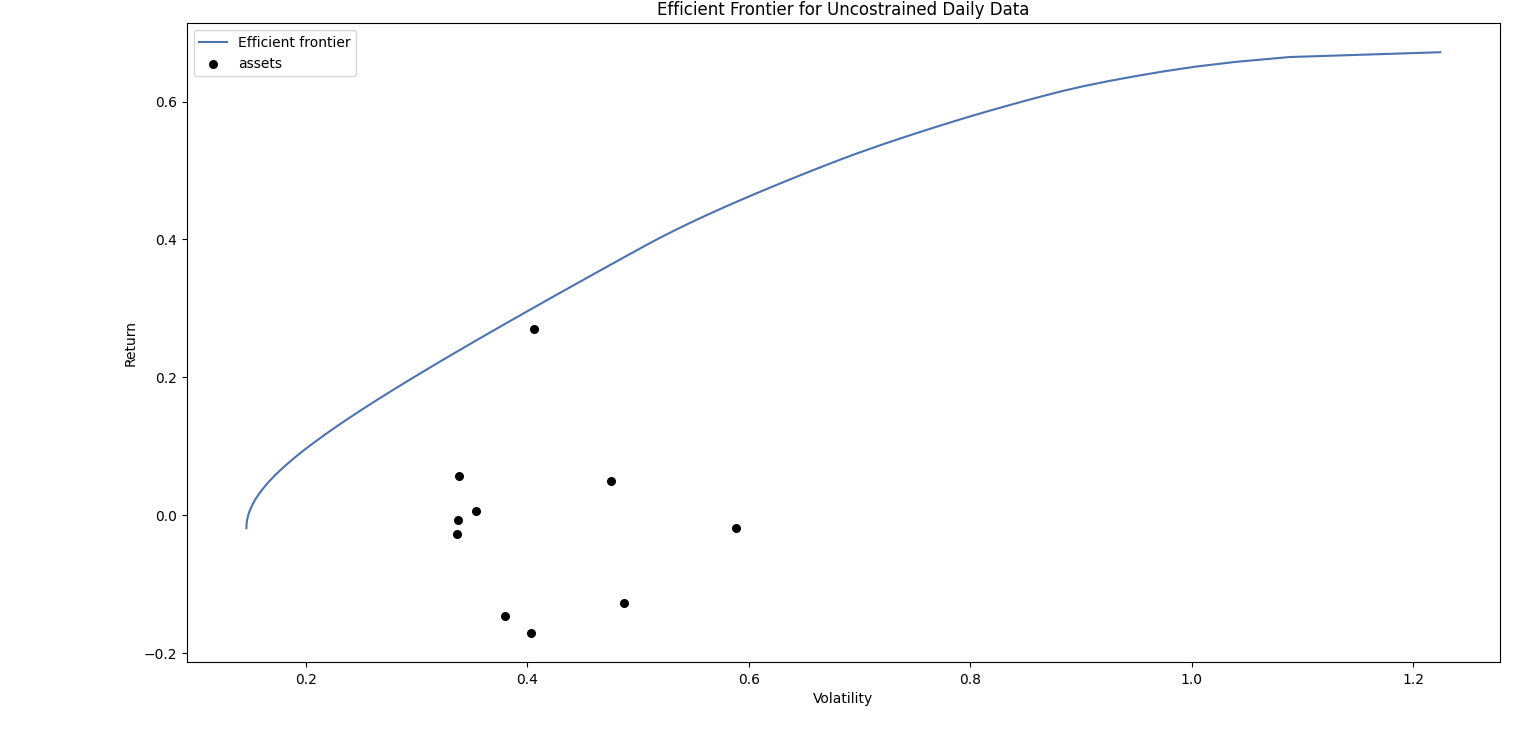

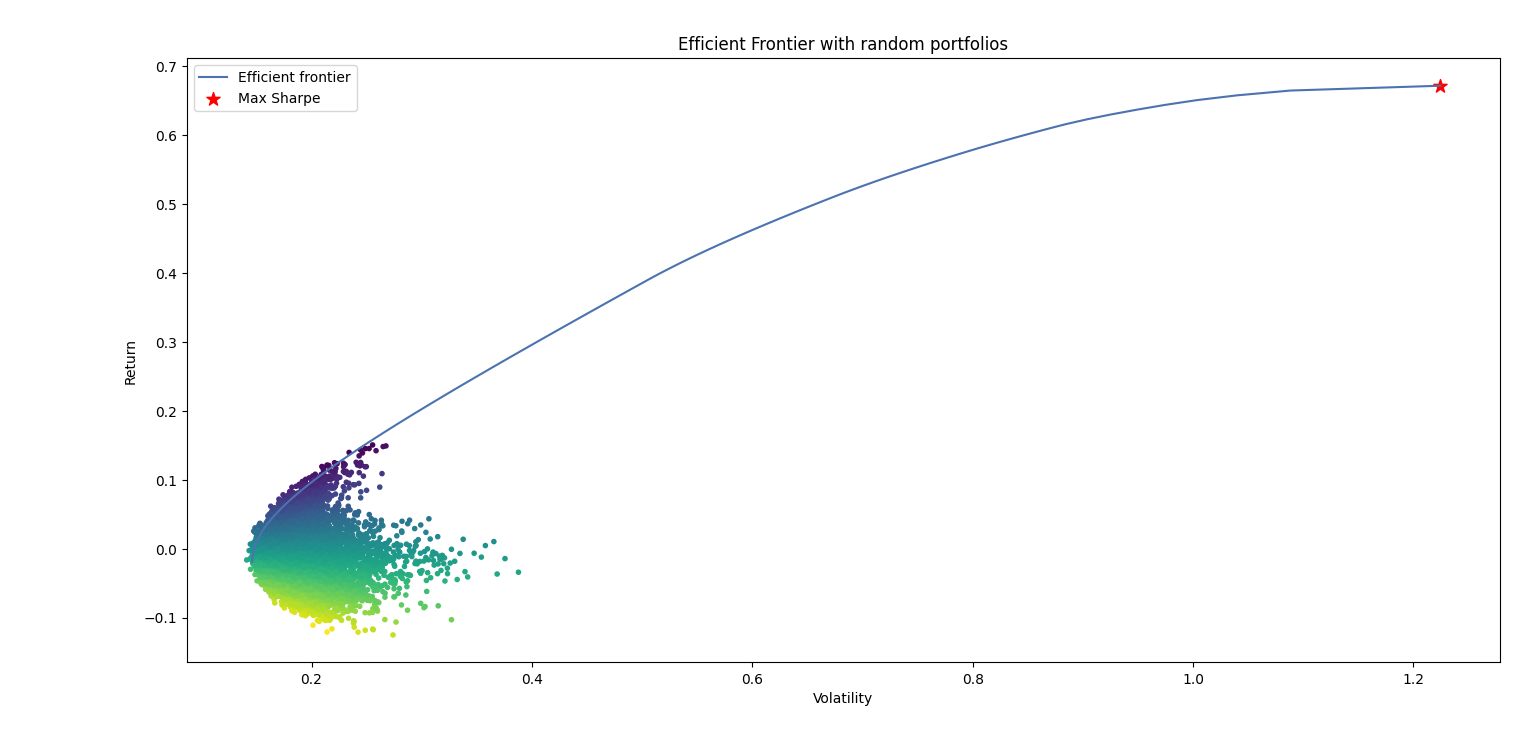

We begin now with the second part that is the analysis of some indexes.
A9. We calculate some statistical properties for the selected one. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
#import MIB daily file QUESTION 9
market_daily_ftse= pd.read_excel ('index.xlsx',skiprows=2, parse_dates=['date'],index_col=0,sheet_name='daily')
market_monthly_ftse= pd.read_excel ('index.xlsx', skiprows=2, parse_dates=['date'],index_col=0,sheet_name='monthly')
#market_daily_ftse = market_daily_ftse['FTSEMIB(PI)']
#market_monthly_ftse=market_monthly_ftse['FTSEMIB(PI)']
#print(market_daily_ftse.head())
#print(market_monthly_ftse.head())

# Extract the 'FTSEMIB(PI)' column
selected_fund_daily = market_daily_ftse['FTSEMIB(PI)']
selected_fund_monthly = market_monthly_ftse['FTSEMIB(PI)']

# Calculate log returns for daily and monthly data
log_returns_daily = np.log(selected_fund_daily / selected_fund_daily.shift(1))
log_returns_monthly = np.log(selected_fund_monthly / selected_fund_monthly.shift(1))

# Calculate mean, variance, standard deviation, skewness, and kurtosis
mean_value_daily = np.mean(log_returns_daily)
variance_value_daily = np.var(log_returns_daily)
std_dev_value_daily = np.std(log_returns_daily)
skewness_value_daily = (log_returns_daily).skew()
kurtosis_value_daily = (log_returns_daily).kurt()

mean_value_monthly = np.mean(log_returns_monthly)
variance_value_monthly = np.var(log_returns_monthly)
std_dev_value_monthly = np.std(log_returns_monthly)
skewness_value_monthly = (log_returns_monthly).skew()
kurtosis_value_monthly = (log_returns_monthly).kurt()

# Print the results for daily data
print("Daily Data:")
print(f"Mean: {mean_value_daily}")
print(f"Variance: {variance_value_daily}")
print(f"Standard Deviation: {std_dev_value_daily}")
print(f"Skewness: {skewness_value_daily}")
print(f"Kurtosis: {kurtosis_value_daily}")

# Print the results for monthly data
print("\nMonthly Data:")
print(f"Mean: {mean_value_monthly}")
print(f"Variance: {variance_value_monthly}")
print(f"Standard Deviation: {std_dev_value_monthly}")
print(f"Skewness: {skewness_value_monthly}")
print(f"Kurtosis: {kurtosis_value_monthly}")

# Create a DataFrame to store the results
results_df = pd.DataFrame({
'Statistic': ['Mean', 'Variance', 'Standard Deviation', 'Skewness', 'Kurtosis'],
'Daily Data': [mean_value_daily, variance_value_daily, std_dev_value_daily, skewness_value_daily, kurtosis_value_daily],
'Monthly Data': [mean_value_monthly, variance_value_monthly, std_dev_value_monthly, skewness_value_monthly, kurtosis_value_monthly]
})


A10. We compute the beta for each security in our portfolio and the for the whole portfolio. 

In [ ]:
# Calculate the market return
market_return_daily = log_returns_daily.mean(axis=1)

# Calculate the beta for each selected stock
betasd = {}
for stock in selected_stocks:
 stock_return = log_returns_daily[stock]
cov = stock_return.cov(market_return_daily)
var = market_return_daily.var()
beta_daily = cov / var
betasd[stock] = beta_daily

# Print the betas for selected stocks
print("Betas for daily Selected Stocks:")
for stock, beta_daily in betasd.items():
 print(f"{stock}: {beta_daily}")



market_return_monthly = log_returns_monthly.mean(axis=1)

# Calculate the beta for each selected stock
betasm = {}
for stock in selected_stocks:
 stock_return = log_returns_monthly[stock]
cov = stock_return.cov(market_return_monthly)
var = market_return_monthly.var()
beta_monthly = cov / var
betasm[stock] = beta_monthly

# Print the betas for selected stocks
print("Betas for monthly Selected Stocks:")
for stock, beta_monthly in betasm.items():
 print(f"{stock}: {beta_monthly}")



A11. Given a RF rate of 3% compute the SML both for 2 securities and for the whole portfolio. 

In [ ]:
annualized_returns = returns.mean() * 252
market_premium = market_return.mean() * 252 - -0.03

betas_range = np.linspace(min(betas.values()), max(betas.values()), 100)
returns_sml = -0.03 + betas_range * market_premium

selected_stocks = ['RATTI', 'BASTOGI', 'MONRIF', 'GAMBERO ROSSO', 'BEEWIZE', 'ECOSUNTEK', 'VIANINI INDR.', 'ENERVIT', 'SABAF', 'ALERION CLEAN POWER']


# Plot the assets
# Plot the assets
plt.figure(figsize=(10, 7))
for asset in selected_stocks:
    if asset in ['ENERVIT', 'VIANINI INDR.']:
        plt.scatter(betas[asset], annualized_returns[asset], marker='*', label=asset, s=150)
    else:
        plt.scatter(betas[asset], annualized_returns[asset], label=asset)

# Plot the SML
plt.plot(betas_range, returns_sml, 'r', label="SML")

plt.xlabel('Beta')
plt.ylabel('Annualized Return')
plt.title('Security Market Line (SML) and Assets Monthy')
plt.legend()
plt.show()


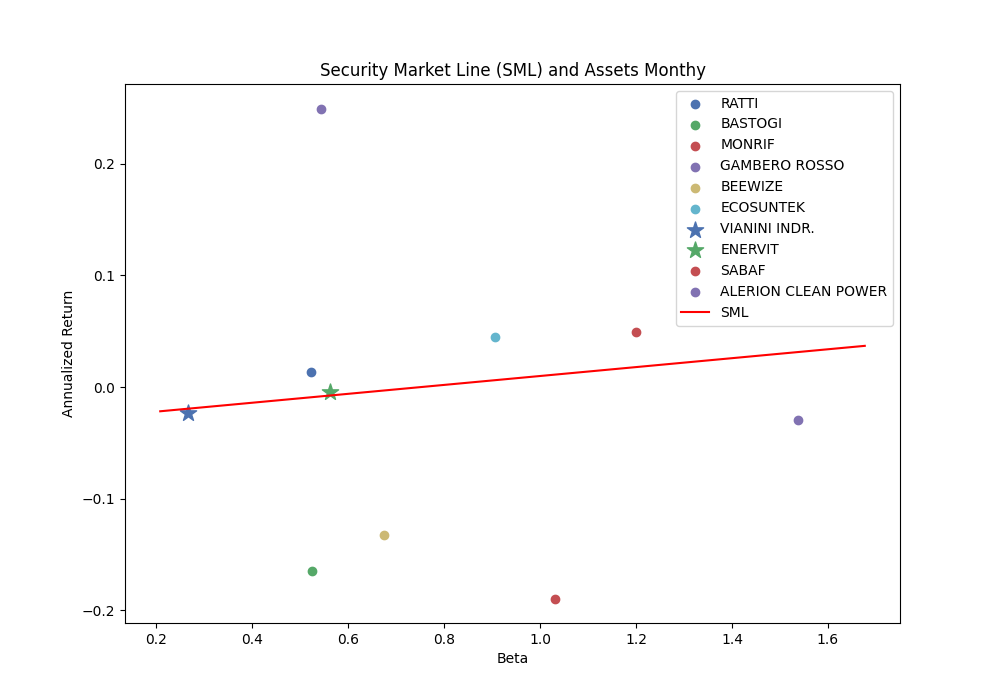 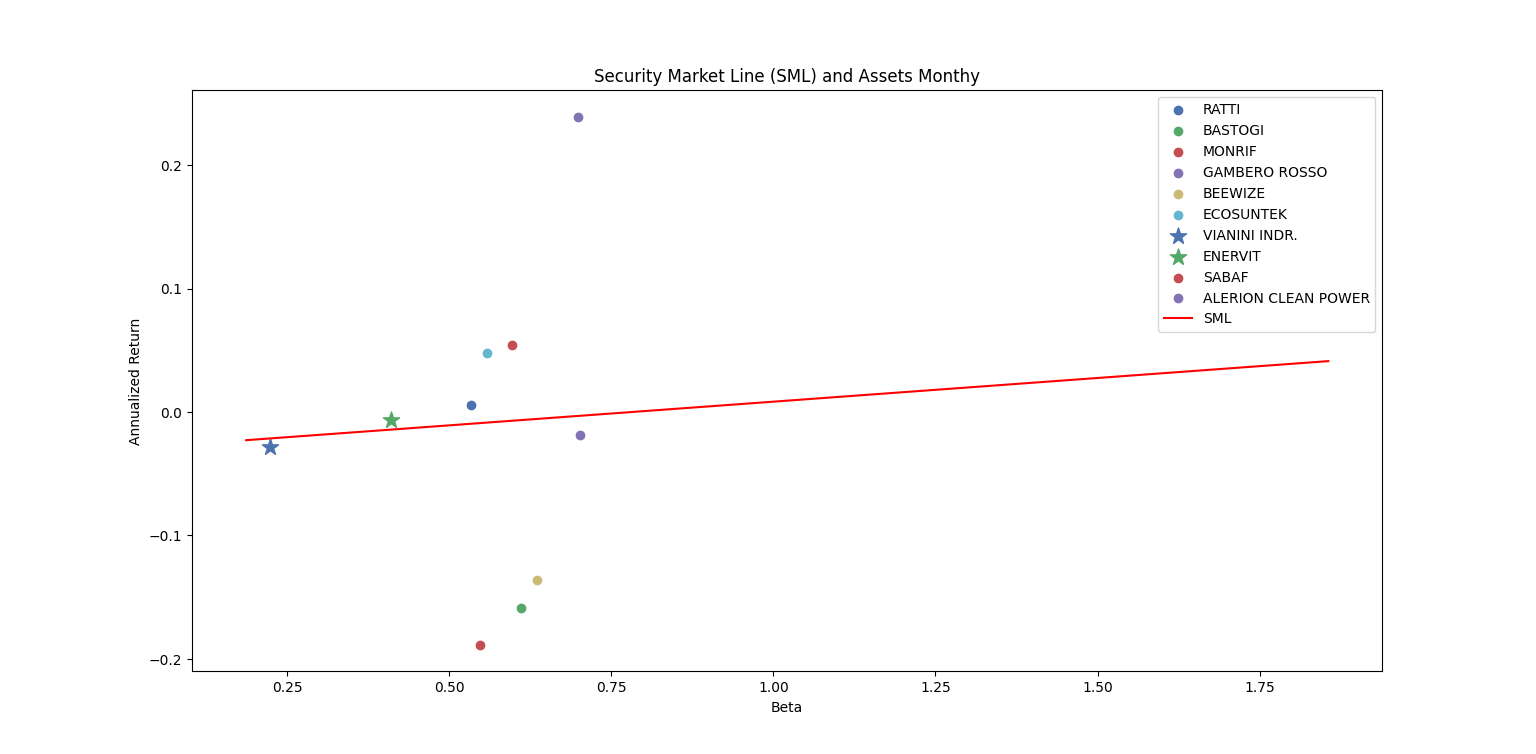

A12. Using BL we implent our views in portfolio allocation. (refer to chapter 7 for justification of the views)

In [ ]:
market_price = df_daily[selected_stocks] #to get the BL with Monthly data just change df_daily with df_monthly



# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(market_price, frequency=252)
S = risk_models.CovarianceShrinkage(market_price, frequency=252).ledoit_wolf()
P = pd.DataFrame([
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [1, 0, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, -1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, -1, 1, 0, 0, 0],
])

confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, 
    0.7 
]

mcaps = {
    'RATTI': 67000000,
    'BASTOGI': 64330000,
    'MONRIF': 10340000,
    'GAMBERO ROSSO': 7370000,
    'BEEWIZE': 5300000,
    'ECOSUNTEK': 36150000,
    'VIANINI INDR.': 84820000,
    'ENERVIT': 56960000,
    'SABAF': 228000000,
    'ALERION CLEAN POWER': 1360000000
}

delta = black_litterman.market_implied_risk_aversion(market_price)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)


Q = pd.Series([0.15, 0.10, 0.05, 0.12, 0.08, 0.1], index=P.index)



bl = BlackLittermanModel(S, pi=market_prior, P=P, Q=Q, omega="idzorek", view_confidences=confidences, market_caps=mcaps)

ret_bl = bl.bl_returns()

S_bl=bl.bl_cov()



ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()


# Assuming 'prices' is your DataFrame with historical prices
returns = ret_bl

# Calculate statistics
mean = returns.mean()
sd = returns.std()
variance = returns.var()
skewness = returns.skew()
kurtosis = returns.kurt()


# Convert weights to a pandas Series
weights_series = pd.Series(weights)

# Convert weights to a pandas DataFrame
weights_df = pd.DataFrame(list(weights.items()), columns=['Asset', 'Weight'])


# Calculate portfolio returns
portfolio_returns = (weights_series * mean).sum()
# Calculate portfolio standard deviation
portfolio_sd = (weights_series * sd).sum()

# Calculate portfolio variance
portfolio_variance = (weights_series * variance).sum()

# Calculate portfolio skewness
portfolio_skewness = (weights_series * skewness).sum()

# Calculate portfolio kurtosis
portfolio_kurtosis = (weights_series * kurtosis).sum()

# Calculate Sharpe Ratio
risk_free_rate = 0.03  # adjust this to your risk free rate
sharpe_ratio = (portfolio_returns - risk_free_rate) / portfolio_sd

# Create DataFrame
statsbl_df = pd.DataFrame({
    'Mean': portfolio_returns,
    'SD': portfolio_sd,
    'Variance': portfolio_variance,
    'Skewness': portfolio_skewness,
    'Kurtosis': portfolio_kurtosis,
    'Sharpe Ratio': sharpe_ratio
}, index=[0])
#print(statsbl_df)


A13. Implementing standard Bayesian Asset Allocation. Assuming conjugate prior normally distributed and a proper prior for the mean, represented by a normal distribution with a mean equal to the mean of your vector of returns + 1*standard deviation. For the matrix covariance matrix of the prior distribution, you can use a perturbation of the original variance-covariance matrix, multiplied by a factor of 2.

In [ ]:
mu = expected_returns.mean_historical_return(market_price, frequency=12)
S = risk_models.CovarianceShrinkage(market_price, frequency=12).ledoit_wolf()

P = pd.DataFrame([
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [1, 0, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, -1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, -1, 1, 0, 0, 0],
])

confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, 
    0.7 
]


Q = pd.Series([0.15, 0.10, 0.05, 0.12, 0.08, 0.1], index=P.index)






mcaps = {
    'RATTI': 67000000,
    'BASTOGI': 64330000,
    'MONRIF': 10340000,
    'GAMBERO ROSSO': 7370000,
    'BEEWIZE': 5300000,
    'ECOSUNTEK': 36150000,
    'VIANINI INDR.': 84820000,
    'ENERVIT': 56960000,
    'SABAF': 228000000,
    'ALERION CLEAN POWER': 1360000000
}

delta = black_litterman.market_implied_risk_aversion(market_price)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

# Create the Black-Litterman model
bl1 = BlackLittermanModel(S, pi=market_prior, P=P, Q=Q, omega="idzorek", view_confidences=confidences, market_caps=mcaps)
prior_mean = mu + 1 * mu.std()
prior_cov = 2 * S
# Update the model with the prior

bl2 = BlackLittermanModel(prior_cov, pi=prior_mean, P=P, Q=Q, omega="idzorek", view_confidences=confidences, market_caps=mcaps)
# Generate the posterior estimates for the returns and covariance matrix
posterior_estimates = bl2.bl_returns()
posterior_covariance = bl2.bl_cov()
print(posterior_covariance)
# Convert posterior_covariance to a pandas DataFrame
posterior_cov_df = pd.DataFrame(posterior_covariance)

# Export the DataFrame as a LaTeX table


# Write the LaTeX table to a file



# Create the Efficient Frontier
efbay = EfficientFrontier(posterior_estimates, posterior_covariance)
efbay.add_objective(objective_functions.L2_reg)
efbay.max_sharpe()
weightsbay = efbay.clean_weights()


# Convert weightsbay to a pandas DataFrame
weightsbay_df = pd.DataFrame(list(weightsbay.items()), columns=['Asset', 'Weight'])


# Compute the mean and standard deviation for the standard Bayesian model




# Compute the mean and standard deviation for the standard Bayesian model
mean, std, sharpe_ratio = efbay.portfolio_performance(verbose=False)

# Compute variance, skewness, and kurtosis
variance = std ** 2
skewness = posterior_estimates.skew()
kurtosis = posterior_estimates.kurt()

# Create a DataFrame
databay = {
    "Mean": [mean],
    "Standard Deviation": [std],
    "Variance": [variance],
    "Skewness": [skewness],
    "Kurtosis": [kurtosis],
    "Sharpe Ratio": [sharpe_ratio]
}

df_statsbay = pd.DataFrame(databay)

print(df_statsbay)




# Initialize results array
num_portfolios = 1000
results = np.zeros((3, num_portfolios))


# Generate random portfolios
for i in range(num_portfolios):
    weights = np.random.random(len(posterior_estimates))
    weights /= np.sum(weights)
    weights_dict = {asset: weight for asset, weight in zip(selected_stocks, weights)}
    ef = EfficientFrontier(posterior_estimates, posterior_covariance, weight_bounds=(0, 1))
    ef.set_weights(weights_dict)
    perf = ef.portfolio_performance(verbose=False)
    results[0, i] = perf[0]  # Return
    results[1, i] = perf[1]  # Volatility
    results[2, i] = perf[2]  # Sharpe Ratio
# Plot the random portfolios
fig, ax = plt.subplots()
scatter = ax.scatter(results[1, :], results[0, :], c=results[2, :], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar(scatter, label='Sharpe Ratio')

# Calculate and plot the efficient frontier for the portfolio with max Sharpe ratio
ef = EfficientFrontier(posterior_estimates, posterior_covariance)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

# Create a new EfficientFrontier object for plotting
ef_for_plotting = EfficientFrontier(posterior_estimates, posterior_covariance)
plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=False)

plt.title('Efficient Frontier with Bayesian Allocation')
plt.xlabel('Volatility')
plt.ylabel('Expected Returns')
plt.show()


A14. Computing GMV portfolio and the statistics. 

In [ ]:
market_price_daily = df_daily[selected_stocks]
market_price_monthly = df_monthly[selected_stocks]



# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu_daily = expected_returns.mean_historical_return(market_price_daily, frequency=252)
S_daily = risk_models.CovarianceShrinkage(market_price_daily, frequency=252).ledoit_wolf()
efgmv_daily = EfficientFrontier(mu_daily, S_daily, weight_bounds=(-1, 1))

weightsgmv_daily = efgmv_daily.min_volatility()
cleaned_weightsgmv_daily = efgmv_daily.clean_weights()
print('\n daily')
perfgmv_daily = efgmv_daily.portfolio_performance(verbose=True)


mu_mont = expected_returns.mean_historical_return(market_price_monthly, frequency=12)
S_mont = risk_models.CovarianceShrinkage(market_price_monthly, frequency=12).ledoit_wolf()
efgmv_mont = EfficientFrontier(mu_mont, S_mont, weight_bounds=(-1, 1))

weightsgmv_mont = efgmv_mont.min_volatility()
cleaned_weightsgmv_mont = efgmv_mont.clean_weights()

perfgmv_mont = efgmv_mont.portfolio_performance(verbose=True)

import scipy.stats as stats

# Calculate skewness and kurtosis for daily and monthly portfolios
# Assuming gmv_returns_daily and gmv_returns_mont are your daily and monthly portfolio returns

# Calculate skewness and kurtosis for daily and monthly portfolio returns
skewness_daily = stats.skew(mu_daily)
kurtosis_daily = stats.kurtosis(mu_daily)
skewness_mont = stats.skew(mu_mont)
kurtosis_mont = stats.kurtosis(mu_mont)

# Create a DataFrame with the calculated skewness and kurtosis
stats_df = pd.DataFrame({
    'Daily': [skewness_daily, kurtosis_daily],
    'Monthly': [skewness_mont, kurtosis_mont]
}, index=['Skewness', 'Kurtosis'])



# Convert cleaned_weightsgmv_daily and cleaned_weightsgmv_mont to pandas DataFrames
weights_dailygmv_df = pd.DataFrame.from_dict(cleaned_weightsgmv_daily, orient='index', columns=['Daily'])
weights_montgmv_df = pd.DataFrame.from_dict(cleaned_weightsgmv_mont, orient='index', columns=['Monthly'])

# Join the DataFrames
weightsgmv_df = weights_dailygmv_df.join(weights_montgmv_df)




mean, std, sharpe_ratio = efgmv_mont.portfolio_performance(verbose=False)
datagmvmonth = {
    "Mean": [mean],
    "Standard Deviation": [std],
    "Sharpe Ratio": [sharpe_ratio]
}

datagmvmonthdf=pd.DataFrame(datagmvmonth)


A15. Finding a way to mix the allocations to maximize the returns. 

In [ ]:
# Creazione di un DataFrame vuoto con gli indici e le colonne desiderate
dfall = pd.DataFrame(index=['MV', 'BL', 'BY', 'GMV'],
                  columns=['Mean', 'Standard Deviation', 'Variance', 'Skewness', 'Kurtosis', 'Sharpe Ratio'])

# Inserimento manuale dei dati nella riga 'MV'
dfall.loc['MV'] = [0.196912,
                0.059593,
                0.003551,
                3.156180,
                9.971121,
                0.682597]

# Inserimento manuale dei dati nelle altre righe, se necessario
dfall.loc['BL'] = [0.051433, 0.076608, 0.005869, 1.812469, 4.264149, 0.279775]
dfall.loc['BY'] = [0.236638, 0.283611, 0.080435, 1.560581, 3.500346, 0.763858]
dfall.loc['GMV'] = [-0.008113, 0.140247, 0.019669, 0.846857, 0.548629, -0.200455]




# Define the weights for each portfolio
weights = {
    'MV': 0.25,
    'BL': 0.25,
    'BY': 0.25,
    'GMV': 0.25
}

# Create a new DataFrame to store the resulting portfolio statistics
resulting_portfolio_equallyweigted = pd.DataFrame(columns=dfall.columns)

# Calculate the resulting portfolio statistics
for stat in dfall.columns:
    resulting_portfolio_equallyweigted.loc['Resulting Portfolio', stat] = sum(weights[port] * dfall.loc[port, stat] for port in weights)

# Display the resulting portfolio statistics
    resulting_portfolio_equallyweigteddf = pd.DataFrame(resulting_portfolio_equallyweigted)

    with open('equallywportfolio.tex', 'w') as f:
     f.write(resulting_portfolio_equallyweigteddf.to_latex())



print(resulting_portfolio_equallyweigteddf)


# Define the weights for each portfolio
weights = {
    'MV': 0.71,
    'BL': 0.13,
    'BY': 0.15,
    'GMV': 0.01
}

# Create a new DataFrame to store the resulting portfolio statistics
resulting_portfolio_ponderated1 = pd.DataFrame(columns=dfall.columns)

# Calculate the resulting portfolio statistics
for stat in dfall.columns:
    resulting_portfolio_ponderated1.loc['Resulting Portfolio', stat] = sum(weights[port] * dfall.loc[port, stat] for port in weights)

# Display the resulting portfolio statistics
    resulting_portfolio_ponderated1df = pd.DataFrame(resulting_portfolio_ponderated1)

   



print(resulting_portfolio_ponderated1)

# Parametri dell'investimento
import matplotlib.pyplot as plt
import numpy as np

# Parametri dell'investimento
P = 100000  # Capitale iniziale
r = 0.18  # Ritorno atteso annuo
sigma = 0.09  # Volatilità
t_max = 10  # Numero massimo di anni

# Calcolo del tasso di ritorno effettivo
r_eff = (r**2 + sigma**2)**0.5

# Periodi di investimento in anni
t_values = np.arange(1, t_max + 1)

# Calcolo del montante finale per ciascun periodo
A_values = P * (1 + r_eff)**t_values

# Creazione del grafico
plt.figure(figsize=(10, 6))
plt.plot(t_values, A_values, marker='o', linestyle='-', color='green')
plt.title('Total principal and interest over time')
plt.xlabel('Yearly Periods')
plt.ylabel('Principal + Interest')
plt.grid(True)
plt.show()